In [18]:
import torch 
import torch.nn as nn 
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
import torch.utils.data as Data
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

In [19]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    #!一段连续数据做data(长度为history_size)，紧邻的一个数据做label
    #!连续滚动,我们就得到了一系列数据和相应的labels
    data = []
    labels = []
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        
        data.append(np.array(dataset[indices]))
        labels.append(np.array(dataset[i+target_size]))
        
    return np.array(data), np.array(labels)

In [20]:
periods = 1000
points_pp = 16 #sine曲线一个周期取多少个点

X = np.arange(0,periods*2*np.pi-2.0*np.pi/points_pp,2.0*np.pi/points_pp)
Y = np.sin(X)*X
ori_data = Y
#step 75%条数据作为训练集，剩下的25%作为验证集
TRAIN_SPLIT = 12000

#step 数据标准化（减去均值，再除以标准差）
train_mean = ori_data[:TRAIN_SPLIT].mean()
train_std = ori_data[:TRAIN_SPLIT].std()
data_Y = (ori_data-train_mean)/train_std

data_Y

array([ 5.13100773e-04,  5.91215715e-04,  8.01775956e-04, ...,
       -3.26465727e+00, -3.01629956e+00, -2.30859968e+00])

In [21]:
from matplotlib import test
from torch import _test_serialization_subcmul


past_history = 48       #! 回看多少个点
future_target = 16      #! 预测多少个点

x_train, y_train = univariate_data(data_Y, 0, TRAIN_SPLIT,
                                        past_history,
                                        future_target)
x_test, y_test = univariate_data(data_Y, TRAIN_SPLIT, None,
                                    past_history,
                                    future_target)

#step numpy转tensor
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float().view(-1,1)
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float().view(-1,1)


batch_size = 64
torch_dataset_train = Data.TensorDataset(x_train, y_train) 
train_loader = Data.DataLoader(dataset=torch_dataset_train, batch_size=batch_size, 
            shuffle=True) 
    
y_train




tensor([[ 5.1310e-04],
        [ 5.5906e-03],
        [ 1.0039e-02],
        ...,
        [-2.2650e+00],
        [-1.7336e+00],
        [-9.3804e-01]])

In [22]:
num_layers=2
hidden_size=16

class LSTM(nn.Module):

    def __init__(self,input_size,hidden_size,num_layers=2,output_size=1):
        super(LSTM, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers) # rnn
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        hidden=torch.zeros(num_layers,x.size(0),hidden_size)
        c=torch.zeros(num_layers,x.size(0),hidden_size)

        x,_ = self.rnn(x) # (seq, batch, hidden)
        x=self.linear(x)
        return x.view(-1,1)

In [23]:
net = LSTM(past_history, hidden_size)
device=torch.device("cuda:0"if torch.cuda.is_available() else "cpu")
net.to(device)
criterion = nn.MSELoss()
optm = torch.optim.Adam(net.parameters(), lr=0.01)
epochs = 1000

In [24]:
epochs_list=[]
train_loss_list=[]
test_error_list=[]
for e in range(epochs):
    epochs_list.append(e)
    for i, (batch_x, batch_y) in enumerate(train_loader):
        batch_x, batch_y=batch_x.to(device), batch_y.to(device)
        y_hat = net(batch_x)
#         print(y_hat.shape)
        loss = criterion(y_hat, batch_y)
        optm.zero_grad()
        loss.backward()
        optm.step()
    
    y = net(x_train.to(device))
    loss = criterion(y.to(device), y_train.to(device))
    train_loss_list.append(loss.item())
    y_pred = net(x_test.to(device))
    error = criterion(y_pred.to(device), y_test.to(device))
    test_error_list.append(error.item())
    if (e+1)%50==0:
        print("Epoch:{}, trainLoss:{}，testLoss:{}".format(e+1,loss.item(),error.item()))

Epoch:50, trainLoss:0.00015441940922755748，testLoss:0.025716815143823624
Epoch:100, trainLoss:0.00010383564949734136，testLoss:0.023884549736976624


KeyboardInterrupt: 

Text(0.5, 0, 'Time')

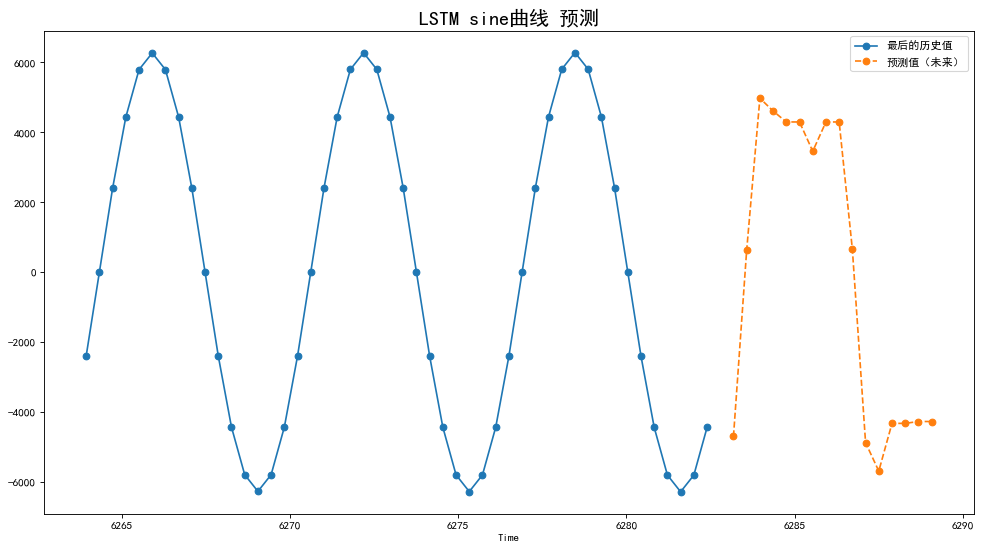

In [27]:
plt.figure(figsize=(15, 8), dpi=80)
plt.plot(X[-past_history:],Y[-past_history:],marker ="o",label ="最后的历史值")
X1 = np.arange(periods*2*np.pi,(periods+1)*2*np.pi - np.pi/8.0 ,np.pi/8.0)
#Y1 = np.sin(X1)
dataY0 = Y[-past_history:].copy()
dataY1 = dataY0.reshape(1,past_history)
predicts = []

net.eval();

for i in range(future_target):  
    dataY=torch.from_numpy(dataY1).float()
    dataY=dataY.to(device)
    predict = net(dataY)
    predict = float(predict)*train_std+train_mean
    predicts.append(predict)
    
    #依次将最新的预测值（单个点）作为添加到用于预测的数据的末端，首端弹出最旧的值
    dataY1[0, 0:-1] = dataY1[0, 1:]
    dataY1[0, -1] = predict


plt.plot(X1,predicts,linestyle="--",marker="o",label ="预测值（未来）")
plt.legend(loc="upper right")
plt.title("LSTM sine曲线 预测",fontsize =18)
plt.xlabel('Time')